<a href="https://colab.research.google.com/github/ShinAsakawa/ShinAsakawa.github.io/blob/master/2022notebooks/2022_0121onomatopea_bert_fine_turing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- filename: 2022_0121onomatopea_bert_fine_tuing.ipynb
- memo: 2022年01月21日現在，
- author: 浅川伸一 askaawa@ieee.org
- lincense: MIT

transformers は M1 Mac では動作しない。Intel Mac such as pasiphae では動作する。

In [1]:
import os
import sys
import numpy as np
import unicodedata
from termcolor import colored

# 本ファイルを Google Colaboratory 上で実行する場合に，必要となるライブラリをインストールする
import platform
isColab = platform.system() == 'Linux'
if isColab:
    !pip install transformers > /dev/null 2>&1 

    # MeCab, fugashi, ipadic のインストール
    !apt install aptitude swig > /dev/null 2>&1
    !aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y > /dev/null 2>&1
    !pip install mecab-python3 > /dev/null 2>&1
    !git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git > /dev/null 2>&1
    !echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n -a > /dev/null 2>&1
    
    import subprocess
    cmd='echo `mecab-config --dicdir`\"/mecab-ipadic-neologd\"'
    path_neologd = (subprocess.Popen(cmd, stdout=subprocess.PIPE,
                                     shell=True).communicate()[0]).decode('utf-8')

    !pip install 'fugashi[unidic]' > /dev/null 2>&1
    !python -m unidic download > /dev/null 2>&1
    !pip install ipadic > /dev/null 2>&1
    !pip install jaconv > /dev/null 2>&1 
    !pip install japanize_matplotlib > /dev/null 2>&1

In [4]:
# 2021/Jan 近藤先生からいただいたオノマトペ辞典のデータの読み込み

#'日本語オノマトペ辞典4500より.xls' は著作権の問題があり，公にできません。
# そのため Google Colab での解法，ローカルファイルよりアップロードしてください
if isColab:
    from google.colab import files
    uploaded = files.upload()  # ここで `日本語オノマトペ辞典4500より.xls` を指定してアップロードする
    data_dir = '.'
else:
    data_dir = '/Users/asakawa/study/2021ccap/notebooks'

import pandas as pd
import jaconv

onomatopea_excel = '2021-0325日本語オノマトペ辞典4500より.xls'
onmtp2761 = pd.read_excel(os.path.join(data_dir, onomatopea_excel), sheet_name='2761語')

#すべてカタカナ表記にしてデータとして利用する場合
#`日本語オノマトペ辞典4500` はすべてひらがな表記だが，一般にオノマトペはカタカナ表記されることが多いはず
#onomatopea = list(sorted(set([jaconv.hira2kata(o) for o in onmtp2761['オノマトペ']])))

# Mac と Windows の表記の相違を吸収
onomatopea = list(sorted(set([jaconv.normalize(o) for o in onmtp2761['オノマトペ']])))
print(f'データファイル名: {os.path.join(data_dir, onomatopea_excel)}\n',
      f'オノマトペ単語総数: len(onomatopea):{len(onomatopea)}')

Saving 2021-0325日本語オノマトペ辞典4500より.xls to 2021-0325日本語オノマトペ辞典4500より.xls
データファイル名: ./2021-0325日本語オノマトペ辞典4500より.xls
 オノマトペ単語総数: len(onomatopea):1741


In [5]:
# 近藤先生 (2021年12月22日） から送っていただいた，オノマトペ文章データ 'original.csv' を読み込む
import jaconv

if isColab:
    uploaded = files.upload()  # original.csv をアップロード
    data_dir = '.'
else:
    data_dir = '/Users/asakawa/study/2021kondo_project'

original = []
n = 0
with open(os.path.join(data_dir,'original.csv'), 'r', encoding='utf8') as f:
    s = f.read()
    for s_ in s.split('\n'):
        if n == 0:
            n += 1
            continue
        idx, sent = s_.split(',')
        
        # Mac と Windows との unicode 符号化の差分を吸収する
        # jaconv.normalize は内部で unicodedata.normalize('NFKC') を呼び出しているので
        # 差異 between Mac and Windows を吸収できる
        sent = ''.join(jaconv.normalize(x) for x in sent)
        original.append(sent)
        #original[int(idx)] = sent

print(f'{len(original)} has been read')

Saving original.csv to original.csv
2469 has been read


In [6]:
%%time
# transformers, huggingface 版の BERT 実装の読み込み
import torch
from transformers import BertConfig
from transformers import BertForPreTraining
from transformers import BertJapaneseTokenizer
from transformers import BertForMaskedLM

model_ja_name = 'cl-tohoku/bert-base-japanese'  # 東北大学乾研による 日本語 BERT 実装
model = BertForMaskedLM.from_pretrained(model_ja_name) # マスク化言語モデルを指定
config = BertConfig.from_pretrained(model_ja_name)

# GPU が利用可能であれば利用する
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

tknz1 = BertJapaneseTokenizer.from_pretrained(model_ja_name)
# BPE (or sentencepiece) による下位単語分割あり

# トークナイザ の修正，実際には onomatopea 単語リストを引数に指定して `add_tokens()` を呼び出すだけ
# ただし，語彙数 tknz.vocab は変更されない。追加された語彙，本コードの場合はオノマトペは，
# `tknz1.added_tokens_encoder` と `tknz1.added_tokens_decoder` に反映されているためである
num_added = tknz1.add_tokens(onomatopea)
print(f'追加されたトークン数:{num_added}/オノマトペ数:{len(onomatopea)}') 
model.resize_token_embeddings(len(tknz1))

print(f' len(tknz1):{len(tknz1)}\n', 
      f'len(tknz1.vocab):{len(tknz1.vocab)}\n',  # 一見すると，この数字からオノマトペが追加されていないように見える。
      f'tknz1.vocab_size:{tknz1.vocab_size}')    # 駄菓子菓子，下で見るように，正しく動作しているように見受けられる

print('# 確認用')
for w in onomatopea[-5:]:
    idx = tknz1.convert_tokens_to_ids(w)
    w_ = tknz1.convert_ids_to_tokens(idx)
    print(f'単語:{w}(id:{idx}) -> token:{w_}')
    

Downloading:   0%|          | 0.00/479 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/252k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/104 [00:00<?, ?B/s]

追加されたトークン数:1711/オノマトペ数:1741
 len(tknz1):33711
 len(tknz1.vocab):32000
 tknz1.vocab_size:32000
# 確認用
単語:わんわ(id:33706) -> token:わんわ
単語:わんわん(id:33707) -> token:わんわん
単語:わーっ(id:33708) -> token:わーっ
単語:わーわー(id:33709) -> token:わーわー
単語:わーん(id:33710) -> token:わーん
CPU times: user 11.6 s, sys: 3.06 s, total: 14.6 s
Wall time: 30.8 s


In [7]:
# こちらも確認用，オノマトペを追加していないトークナイザwを tknz2 とする
tknz2 = BertJapaneseTokenizer.from_pretrained(model_ja_name)

In [8]:
#トークナイザの違い，オノマトペを登録した場合と，東北大学乾研提供のトークナイザを使った場合との相違 タブで区切られているテキストファイルとして出力
with open('2022_0121onomatopea_tokenizer_difference.txt', 'w', encoding='utf8') as fo:
    fo.write('#トークナイザの違い，オノマトペを登録した場合と，東北大学乾研提供のトークナイザを使った場合との相違 タブで区切られているテキストファイルとして出力\n')

    for s in original:
        fo.write("/".join(tknz1.tokenize(s)))
        fo.write("\t")
        fo.write("/".join(tknz1.tokenize(s)))
        fo.write("\n")

!head 2022_0121onomatopea_tokenizer_difference.txt

#トークナイザの違い，オノマトペを登録した場合と，東北大学乾研提供のトークナイザを使った場合との相違 タブで区切られているテキストファイルとして出力
日/が/射/##し/たり/光/が/ぽっ/と/とも/##る	日/が/射/##し/たり/光/が/ぽっ/と/とも/##る
あ/##たた/##かい/日/ざ/##し/が/ぽかぽか/(/と/)/差/し/##こ/##む	あ/##たた/##かい/日/ざ/##し/が/ぽかぽか/(/と/)/差/し/##こ/##む
水/や/日/ざ/##し/が/なんなん/(/と/)/満ち/満ち/##る	水/や/日/ざ/##し/が/なんなん/(/と/)/満ち/満ち/##る
すっ/かり/日/が/とっぷり/(/と/)/暮れ/##る	すっ/かり/日/が/とっぷり/(/と/)/暮れ/##る
日光/が/てかてか/(/と/)/照/##り/##輝/##く	日光/が/てかてか/(/と/)/照/##り/##輝/##く
雲/ひとつ/なく/すかっ/と/晴れ/##上がる	雲/ひとつ/なく/すかっ/と/晴れ/##上がる
太陽/が/じりじり/(/と/)/焼け/つく/よう/に/照/##る	太陽/が/じりじり/(/と/)/焼け/つく/よう/に/照/##る
日/ざ/##し/が/さんさん/(/[UNK]/)/と/いっぱい/に/差し/##込む	日/ざ/##し/が/さんさん/(/[UNK]/)/と/いっぱい/に/差し/##込む
曇/##っ/て/い/た/空/が/けろり/と/明るく/晴れ/##る	曇/##っ/て/い/た/空/が/けろり/と/明るく/晴れ/##る


In [9]:
import re
# # ランダムサンプリングしてデータを印字して確認
# for _ in range(3):
#     N = np.random.randint(low=0, high=len(original))
#     sent0 = original[N]
#     sent1 = re.sub('\(と\)','と',original[N]) # original に含まれる `(と)` のような表現を削除する
    
#     print(colored(sent0, attrs=['bold']))  # 送っていただいた元の文
#     print(colored('\t分かち書き','blue'), tknz1.tokenize(sent0)) # その分かち書き
#     print(colored('\tトークン ID', 'blue'), tknz1.encode(sent0))     # 分かち書き結果の単語 ID 化

#     if sent0 != sent1:
#         print(colored('\t分かち書き','red'), tknz1.tokenize(sent1)) # その分かち書き
#         print(colored('\tトークンID', 'red'), tknz1.encode(sent1))      # 分かち書き結果の単語 ID 化

# MeCab で単語分割が行われて、MeCab が単語として認識しても、その単語が語鎮リスト vocab.txt に登録されていない場合は
# subword である WordPiece が起動され、その単語が適当に分割されます。そのように分割された単語には '##' が単語の前に付与されます。
# また、未知語の場合もWordPieceが起動され、同様に分割されます。

print('\n', '-' * 77)
print('# 以下は，特殊トークンと対応するトークン ID との関係を表示。')
print('# 英語版で標準的に用いられる `bert-base-uncased` と東北大学乾研の特殊トークンの ID は異なることに注意')
print(colored(f'tknz.all_special_ids:{tknz1.all_special_ids}',attrs=['bold']))  #  [1, 3, 0, 2, 4]
print(colored(f'tknz.all_special_tokens:{tknz1.all_special_tokens}', attrs=['bold']))  #  ['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']


 -----------------------------------------------------------------------------
# 以下は，特殊トークンと対応するトークン ID との関係を表示。
# 英語版で標準的に用いられる `bert-base-uncased` と東北大学乾研の特殊トークンの ID は異なることに注意
tknz.all_special_ids:[1, 3, 0, 2, 4]
tknz.all_special_tokens:['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']


In [10]:
max_token_len = np.array([len(tknz1(s).input_ids) for s in original]).max()
max_token_len += 2  # 保険のため 2 くらい加えておく
print(f'max_token_len:{max_token_len}')

# トークナイザにかけて出力を得る。`max_length` のデフォルトは 512 だが，今回は長文である必要がないと考えられる。
# ここでは `max_token_len = 23` にしている。512 でも動作するが，学習に要する時間が増える
text = tuple(original)  # 全文をタプルに変換
inputs = tknz1(text, 
               return_tensors='pt', 
               max_length=max_token_len, 
               truncation=True, 
               padding='max_length')

#`labels` キーを追加する。実際には inputs_ids なのでラベルではなくトークンID の系列
inputs['labels'] = inputs.input_ids.detach().clone()

#トークン ID を走査して，オノマトペ単語であれば，[MASK] トークンに置き換える。
l_ = []
for l in inputs['labels']:
    l_.append([tknz1.mask_token_id if w in onomatopea else tknz1.convert_tokens_to_ids(w) for w in tknz1.convert_ids_to_tokens(l)])

inputs['input_ids'] = torch.LongTensor(l_)
#print(inputs['input_ids'].shape)

max_token_len:23


In [ ]:
#データセットのためのクラスを定義
class onmtpDataset(torch.utils.data.Dataset):
    def __init__(self, encoder):
        self.encoder = encoder
        
    def __getitem__(self, idx):
        return {key:torch.tensor(val[idx]) for key, val in self.encoder.items()}
    
    def __len__(self):
        return len(self.encoder.input_ids)
    
dataset = onmtpDataset(inputs)

#データローダを準備
loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

# GPU/CPU 使用を設定し，モデルの訓練モードを起動 #Setup GPU/CPU usage and activate the training mode of our model.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# そしてモデルを選択したデバイスに移動 # and move our model over to the selected device
model.to(device)
# 訓練モードに設定 #activate training mode
model.train()

In [15]:
#最適化関数を初期化 (AdamW は重み付き崩壊で，過学習の可能性を減らす) 
#Initialize our optimizer (Adam with weighted decay - reduces chance of overfitting).
from transformers import AdamW
#最適化関数を初期化 # initialize optimizer
optim = AdamW(model.parameters(), lr=5e-5)

In [39]:
from tqdm import tqdm  # 進捗状況の可視化のため

epochs = 30  # 学習回数を指定

losses = []
for epoch in range(epochs):
    # setup loop with TQDM and dataloader
    loop = tqdm(loader, leave=True)
    for batch in loop:

        optim.zero_grad()  # 学習に用いる BERT パラメータの勾配を 0 で初期化

        input_ids = batch['input_ids'].to(device)  # ミニバッチサイズだけデータを取得
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # BERT を呼び出して結果を得る
        outputs = model(input_ids, 
                        attention_mask=attention_mask,
                        labels=labels)

        loss = outputs.loss  # 損失値を取得
        loss.backward()      # 取得した損失値に基づいて BERT のパラメータを逆伝播
        optim.step()         # BERT パラメータの更新 すなわち学習
        
        loop.set_description(f'Epoch {epoch}') # 進行状況の表示
        loop.set_postfix(loss=loss.item())
        losses.append(loss.item())

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Epoch 29: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s, loss=0.0228]


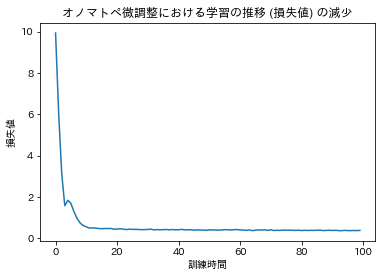

In [17]:
len(losses)
import matplotlib.pyplot as plt
import japanize_matplotlib

plt.plot(losses[:100])
plt.xlabel('訓練時間')
plt.ylabel('損失値')
plt.title('オノマトペ微調整における学習の推移 (損失値) の減少')
plt.show()

In [41]:
model.to(device)
model.eval()

def eval_an_output(N, original=original, tknz1=tknz1, inputs=inputs, print_flag=True):
    """
    引数として 数字を 1 つ入力すると (N)，`original.csv` の N 行目のデータを読み込んで，
    その文のオノマトペを [MASK] に置き換えて，マスク化言語モデルで [MASK] を予測する。
    結果を表示する場合には 引数 `print_flag=True` として呼び出す
    """
    if N >= len(original) or (not isinstance(N, int)):
        return

    _out = model(inputs.input_ids[N].unsqueeze(0).to(device), attention_mask=inputs.attention_mask[N].unsqueeze(0).to(device), labels=inputs.labels[N].to(device))
    _x = _out.logits.detach()
    __x = _x.squeeze(0).detach().clone()
    _pred_idx  = torch.argmax(__x, dim=1, keepdim=True)
    _pred_s    = "/".join(tknz1.convert_ids_to_tokens(_pred_idx)).replace('/[PAD]','')
    
    _orig      = original[N] # 原文
    _inp_idx   = tknz1.convert_ids_to_tokens(inputs.input_ids[N]) # 入力トークンID
    _inp_s     = "/".join(_inp_idx).replace('/[PAD]','')          # 入力文
    _teach_idx = tknz1.convert_ids_to_tokens(inputs.labels[N])    # 教師信号トークンID
    _teach_s   = "/".join(_teach_idx).replace('/[PAD]','')        # 教師信号文
    
    _mask_pos = np.where(inputs.input_ids[N].detach().numpy() == tknz1.mask_token_id)
    _teach_tokens = inputs.labels[N][_mask_pos].detach().squeeze().numpy()
    _pred_tokens  = _pred_idx[_mask_pos].detach().squeeze().cpu().numpy()

    _n_hit = np.array([_teach_tokens == _pred_tokens]).sum()       # 正解したか否か
    if print_flag:
        color = 'grey' if _n_hit > 0 else 'red'
        print(f'{N:5,d}   原文:{_orig}')
        print(f'\t入力:{_inp_s}')
        print(f'\t正解:{_teach_s}')
        print(colored(f'\t出力:{_pred_s}',color))
        print(f'\tmask 位置:{_mask_pos}')
        print(f'\t正解トークン:{_teach_tokens}', f'予測トークン:{_pred_tokens}', 
              f'{np.array([_teach_tokens == _pred_tokens]).sum() > 0}')
        print(f'\t_out.loss:{_out.loss:.3f}')
    
    return _out.loss, _n_hit

total_hit = 0
for i in range(len(original)):
    _, hit = eval_an_output(i, print_flag=True) # print_flag = True にすると推論結果を表示します. 逆に False にすれば正解率だけ計算します
    total_hit += hit

print(f'正解数:{total_hit}/{len(original)}= {total_hit/len(original) * 100:.3f} %')    

Streaming output truncated to the last 5000 lines.
	_out.loss:0.049
1,755   原文:しわが寄ってしわくしゃ(と)縮れる
	入力:[CLS]/し/##わ/が/寄/##っ/て/[MASK]/(/と/)/縮/##れる/[SEP]
	正解:[CLS]/し/##わ/が/寄/##っ/て/しわくしゃ/(/と/)/縮/##れる/[SEP]
	出力:[CLS]/し/##わ/が/寄/##っ/て/しわくしゃ/(/と/)/縮/##れる/[SEP]
	mask 位置:(array([7]),)
	正解トークン:32633 予測トークン:32633 True
	_out.loss:0.019
1,756   原文:細長く弱々しげにひょろひょろ(と)のびる
	入力:[CLS]/細長く/弱/##々/##し/げ/に/[MASK]/(/と/)/のび/##る/[SEP]
	正解:[CLS]/細長く/弱/##々/##し/げ/に/ひょろひょろ/(/と/)/のび/##る/[SEP]
	出力:[CLS]/細長く/弱/##々/##し/げ/に/ひょろひょろ/(/と/)/のび/##る/[SEP]
	mask 位置:(array([7]),)
	正解トークン:33190 予測トークン:33190 True
	_out.loss:0.001
1,757   原文:よくびよーんとのびる
	入力:[CLS]/よく/[MASK]/と/のび/##る/[SEP]
	正解:[CLS]/よく/びよーん/と/のび/##る/[SEP]
	出力:[CLS]/よく/びよーん/と/のび/##る/[SEP]
	mask 位置:(array([2]),)
	正解トークン:33234 予測トークン:33234 True
	_out.loss:0.001
1,758   原文:障りなくのびのび(と)のびたり成長する
	入力:[CLS]/障/##り/なく/[MASK]/(/と/)/の/[MASK]/成長/する/[SEP]
	正解:[CLS]/障/##り/なく/のびのび/(/と/)/の/びたり/成長/する/[SEP]
	出力:[CLS]/障/##り/なく/のびのび/(/と/)/の/びたり/成長/する/[SEP]
	mask 位置:(array([4, 9]),)
	正解トークン:[3

In [ ]:
torch.save(model.state_dict(), '2022_0120onomatopea.pt')
#model = BertForMaskedLM.from_pretrained(model_ja_name)
model.load_state_dict(torch.load('2022_0120onomatopea.pt'))


<All keys matched successfully>